In [1]:
#let's get into the real job!
#check whether tensorflow is correctly installed
import tensorflow as tf
print(tf.__version__)

2.0.0


In [2]:
#load data 
import numpy as np
x_train, y_train = np.load("train_x.npy"), np.load("train_y.npy")
x_test, y_test = np.load("test_x.npy"), np.load("test_y.npy")

In [3]:
print(np.shape(x_train), np.shape(y_train), np.shape(x_test), np.shape(y_test))

(19257, 24) (19257, 1) (4815, 24) (4815, 1)


In [4]:
from tensorflow import keras
from tensorflow.keras import layers
#make DNN
dnn = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[24]),
    layers.Dense(128, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dense(516, activation='sigmoid'),
    layers.Dropout(0.5),
    layers.Dense(1)
  ])

2021-09-19 10:41:00.648003: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2021-09-19 10:41:00.648723: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 16. Tune using inter_op_parallelism_threads for best performance.


In [5]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005, beta_1=0.9, beta_2=0.999, epsilon=1e-07)

In [6]:
#Once the model is created, you can config the model with losses and metrics
#with model.compile(), 
#train the model with model.fit(), 
#or use the model to do prediction with model.predict().
dnn.compile(loss='mse', optimizer=optimizer, metrics=['mse'])

In [7]:
dnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                1600      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_2 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_3 (Dense)              (None, 516)               132612    
_________________________________________________________________
dropout (Dropout)            (None, 516)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 517       
Total params: 176,073
Trainable params: 176,073
Non-trainable params: 0
__________________________________________________

In [8]:
#let's do whether model works okay
example_batch = x_train[0:2]
example_result = dnn.predict(example_batch)

In [9]:
example_result
print(np.shape(x_train[0:2]), np.shape(example_result))

(2, 24) (2, 1)


In [10]:
#Let's do training with model.fit
EPOCHS = 200
history = dnn.fit(
  x_train, y_train,
  epochs=EPOCHS, validation_split = 0.1, verbose=1)

Train on 17331 samples, validate on 1926 samples
Epoch 1/200
17331/17331 [==============================] - 8s 478us/sample - loss: 0.1138 - mse: 0.1138 - val_loss: 0.0051 - val_mse: 0.0051
Epoch 2/200
17331/17331 [==============================] - 6s 340us/sample - loss: 0.0060 - mse: 0.0060 - val_loss: 0.0031 - val_mse: 0.0031
Epoch 3/200
17331/17331 [==============================] - 6s 353us/sample - loss: 0.0036 - mse: 0.0036 - val_loss: 0.0016 - val_mse: 0.0016
Epoch 4/200
17331/17331 [==============================] - 6s 346us/sample - loss: 0.0019 - mse: 0.0019 - val_loss: 0.0014 - val_mse: 0.0014
Epoch 5/200
17331/17331 [==============================] - 6s 334us/sample - loss: 0.0016 - mse: 0.0016 - val_loss: 9.1584e-04 - val_mse: 9.1584e-04
Epoch 6/200
17331/17331 [==============================] - 6s 339us/sample - loss: 0.0014 - mse: 0.0014 - val_loss: 0.0012 - val_mse: 0.0012
Epoch 7/200
17331/17331 [==============================] - 6s 334us/sample - loss: 0.0013 - mse: 

In [11]:
import pandas as pd

In [12]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mse,val_loss,val_mse,epoch
195,0.000684,0.000684,0.000790,0.000790,195
196,0.000670,0.000670,0.000757,0.000757,196
197,0.000675,0.000675,0.000868,0.000868,197
198,0.000665,0.000665,0.000799,0.000799,198
199,0.000698,0.000698,0.000772,0.000772,199


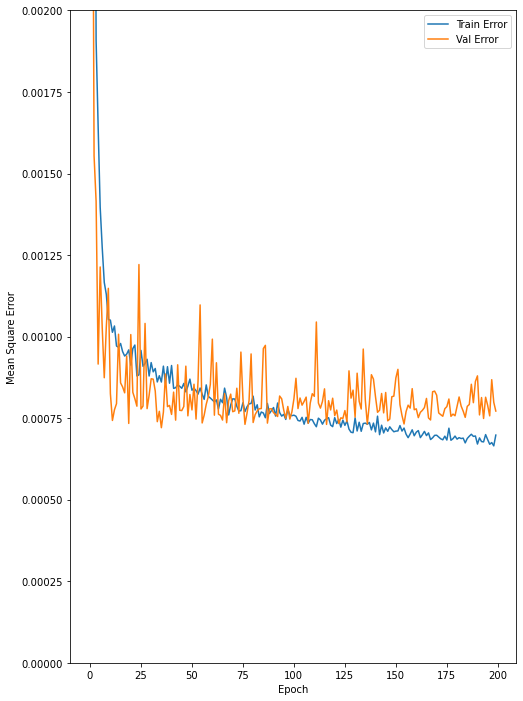

In [13]:
import matplotlib.pyplot as plt

def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure(figsize=(8,12))

  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  plt.ylim([0,0.002])
  plt.legend()
  plt.show()

plot_history(history)

In [14]:
test_predictions = dnn.predict(x_test).flatten()
print(np.shape(y_test), np.shape(test_predictions))

(4815, 1) (4815,)


In [15]:
#Evaluate with test set
loss,  mse = dnn.evaluate(x_test, y_test, verbose=2)
pm25_max = 149.0
pm25_min = 1.0
mse = mse*(pm25_max-pm25_min) + pm25_min
print("MSE of testset: {:5.2f} ug/m^3".format(mse))

4815/1 - 1s - loss: 4.6285e-04 - mse: 6.9676e-04
MSE of testset:  1.10 ug/m^3


In [16]:
#de-normalization
for i in range(len(y_test)):
    y_test[i,0] = y_test[i,0]*(pm25_max-pm25_min)+pm25_min
    test_predictions[i] = test_predictions[i]*(pm25_max-pm25_min)+pm25_min

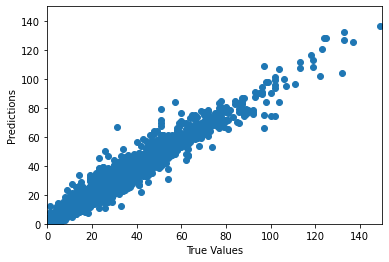

In [17]:
# plot results
plt.scatter(y_test, test_predictions)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.ylim([0,150])
plt.xlim([0,150])
plt.show()

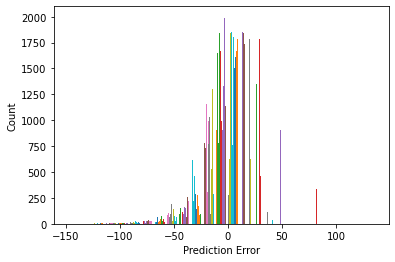

In [18]:
error = test_predictions - y_test
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error")
_ = plt.ylabel("Count")